# Agent-Based Kinetics via Topology (ABa-KiTo)
Date: 19.11.2025

In this notebook I realized a graph analysis for the clusterin results of the simulation when the network topology is a small-world networks for the voter dynamics

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist
import pickle


import sys
import os
import torch as pt
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("NumPy version:", np.__version__)
print("Torch version:", pt.__version__)


NumPy version: 1.26.4
Torch version: 2.3.0+cpu


In [3]:
# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..",'..'))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.modules_mokito import *


In [4]:
#Load data formatted from ABM simulations and ISOKANN.jl 

sims_path = os.path.join('ABa-KiTo', 'majority_rule', 'data', 'simulations','')
data_dir =  os.path.join(project_root, sims_path)

# Read data
states_data = np.load(data_dir + '2025-11-18-data_majority_rule.npz')
xs = states_data['xs'] #xs.shape (n_dim, n_samples)
ys = states_data['ys'] #ys-shape (n_dim, n_koop = 1, n_samples)

#Reshape data to use it for MoKiTo
X0 = xs.T #(n_samples, n_dim)
Xt = np.transpose(ys, (2, 1, 0))   # (n_samples, 1, n_dim)

# --- Log + Scale both X0 and Xt consistently ---
scaler = StandardScaler()

# X0
X0_log = np.log1p(X0)
X0_scaled = scaler.fit_transform(X0_log)   # (n_samples, n_dim)

# Xt: flatten for scaling
Xt_flat = Xt.reshape(-1, Xt.shape[2])      # (n_samples * n_koop, n_dim)
Xt_log = np.log1p(Xt_flat)
Xt_scaled = scaler.transform(Xt_log)
Xt_scaled = Xt_scaled.reshape(Xt.shape)    # (n_samples, 1, n_dim)


# # # --- Load chi function ---
chivals_path = os.path.join('ABa-KiTo', 'majority_rule','data',  'chi_vals', '')
chivals_dir = os.path.join(project_root, chivals_path)
chi0 = np.load(chivals_dir + 'chi_values_MR.npz')

# --- Organize for MoKiTo ---
data = OrganizeData(X0_scaled, Xt_scaled, chi0)





Check shape of input data
X0.shape   =  (200000, 202)
Xt.shape   =  (200000, 1, 202)
chi0.shape =  (200000,)
  


In [5]:
#Reload clustering results:
# Load the specific run you want to use (Nintervals=5, seed=42 for example)
clustering_dir = os.path.join( "..", 'data', 'clustering_results')
n_intervals = 3
seed = 123
with open(f'{clustering_dir}/Nint{n_intervals}_seed{seed}_FNs.pkl', 'rb') as f:
    FNs = pickle.load(f)

with open(f'{clustering_dir}/Nint{n_intervals}_seed{seed}_FCs.pkl', 'rb') as f:
    FIs = pickle.load(f)

In [6]:
#Clustering results
noise_pct = np.sum(FNs.nodes == -1) / len(FNs.nodes) * 100
print(f"Result: {FNs.Nnodes} clusters, {noise_pct:.1f}% noise\n\n")
print(f"Cluster sizes - min: {FNs.nodes_size.min()}, max: {FNs.nodes_size.max()}, median: {np.median(FNs.nodes_size):.0f}")
print(f"Clusters per interval: {[np.sum(FNs.index_chi_node == i) for i in range(FIs.Nintervals)]}\n")

for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])

Result: 7 clusters, 7.5% noise


Cluster sizes - min: 1907, max: 106108, median: 3012
Clusters per interval: [2, 2, 3]

Node, interval, size: 0 0 25219
Node, interval, size: 1 0 106108
Node, interval, size: 2 1 2069
Node, interval, size: 3 1 44089
Node, interval, size: 4 2 1907
Node, interval, size: 5 2 2545
Node, interval, size: 6 2 3012



χ-function interval distribution:
chi0 range: [-0.003, 1.026]
chi0 mean: 0.209, std: 0.163
  Interval 0: 141764 points ( 70.9%), χ ∈ [-0.003, 0.225]
  Interval 1:  50138 points ( 25.1%), χ ∈ [0.225, 0.579]
  Interval 2:   8098 points (  4.0%), χ ∈ [0.579, 1.026]


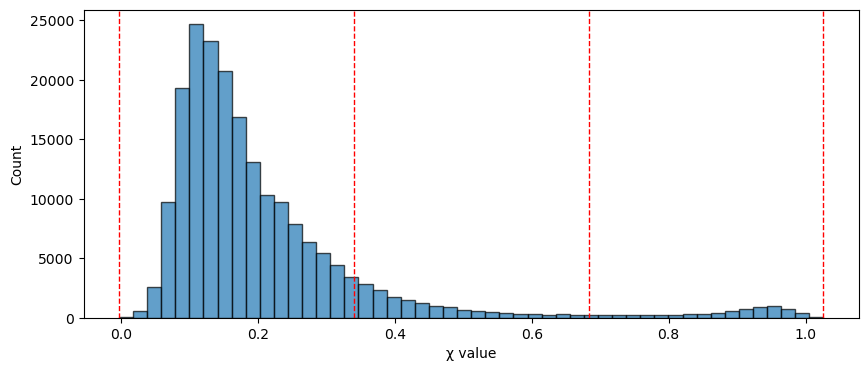

In [7]:
print("\nχ-function interval distribution:")
print(f"chi0 range: [{data.chi0.min():.3f}, {data.chi0.max():.3f}]")
print(f"chi0 mean: {data.chi0.mean():.3f}, std: {data.chi0.std():.3f}")

chi_bins = []  # list to store (min, max) tuples

for i in range(FIs.Nintervals):
    interval_points = FIs.size_intervals[i] if i < len(FIs.size_intervals) else 0
    chi_vals = data.chi0[FIs.chi_intervals == i]

    if len(chi_vals) > 0:
        chi_min, chi_max = chi_vals.min(), chi_vals.max()
        chi_bins.append((chi_min, chi_max))
        print(f"  Interval {i}: {interval_points:6d} points ({interval_points/len(data.chi0)*100:5.1f}%), "
              f"χ ∈ [{chi_min:.3f}, {chi_max:.3f}]")
    else:
        chi_bins.append((None, None))  # placeholder for empty interval
        print(f"  Interval {i}: {interval_points:6d} points (empty)")

# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(data.chi0, bins=50, edgecolor='black', alpha=0.7)
intervals = n_intervals
for edge in np.linspace(data.chi0.min(), data.chi0.max(), intervals + 1):
    plt.axvline(edge, color='red', linestyle='--', linewidth=1)
plt.xlabel('χ value')
plt.ylabel('Count')
#plt.title('Distribution of χ values with interval boundaries')
#plt.show()

#Create results directory
path = os.path.join('ABa-KiTo', 'majority_rule', 'data')
data_dir = os.path.join(project_root, path)

graphs_dir = os.path.join(data_dir, 'graphs_results')
os.makedirs(graphs_dir, exist_ok=True)
results_dir = graphs_dir

plt.savefig(f"{results_dir}/distribution_of_chi_values_with_interval_boundaries_MR.pdf", bbox_inches = 'tight')

Text(0, 0.5, 'Green Output Share')

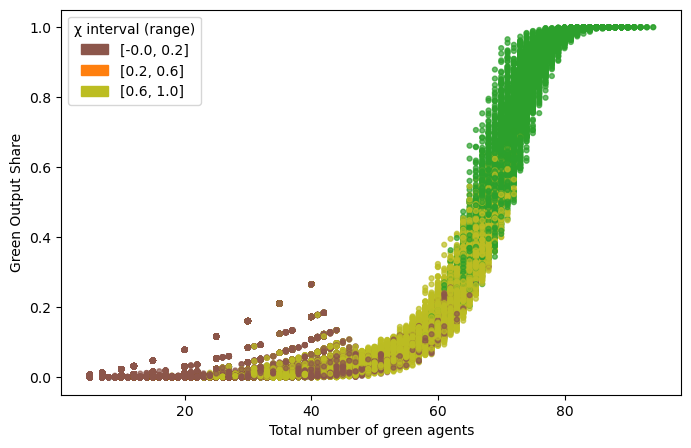

In [11]:
#Scatter plot of macro variables colored by chi interval for practical interpretation of ISOKANN output
# Example data
import matplotlib.colors as mcolors

macro = X0[:, -2:]
chi_intervals = FIs.chi_intervals  # values: 0, 1, 2

macro1 = "Total number of green agents"
macro2 = "Green Output Share"

labels = [f"[{low:.1f}, {high:.1f}]" for low, high in chi_bins]

# Create a colormap with exactly 3 colors
#cmap = mcolors.ListedColormap(['tab:brown', 'tab:olive',  'tab:green'])
cmap = mcolors.ListedColormap(['tab:brown', 'tab:orange', 'tab:olive', 'tab:green'])


# Set boundaries to match chi intervals (for coloring)
bounds = [0, 1, 2, 3]  # edges for 0,1,2

# Plot
plt.figure(figsize=(8,5))
sc = plt.scatter(macro[:,0], macro[:,1],
                 c=chi_intervals, cmap=cmap,
                 s=12, alpha=0.7)

# Create a custom legend
from matplotlib.patches import Patch
handles = [Patch(color=cmap(i), label=label) for i, label in enumerate(labels)]
plt.legend(handles=handles, title="χ interval (range)")

plt.xlabel(macro1)
plt.ylabel(macro2)
#plt.title("Macro variables colored by chi interval")
#plt.show()
#plt.savefig("N3intervals_results/macro_vars_colored_by_chi_interval.pdf")

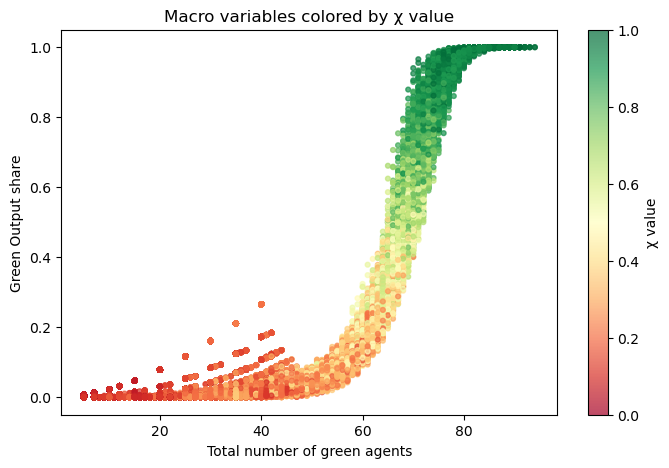

In [32]:
#Scatter plot of macro variables colored by chi interval for practical interpretation of ISOKANN output
# Example data
import matplotlib.colors as mcolors

macro = X0[:, -2:]
chi_intervals = FIs.chi_intervals  # values: 0, 1, 2

macro1 = "Total number of green agents"
macro2 = "Green Output share"

labels = [f"[{low:.1f}, {high:.1f}]" for low, high in chi_bins]

#color map
#cmap=plt.cm.viridis
cmap=plt.cm.RdYlGn


# Plot
plt.figure(figsize=(8,5))
sc = plt.scatter(macro[:,0], macro[:,1],
                 c=chi0, #chi_values, 
                 cmap=cmap,
                 s=12, alpha=0.7,
                 vmin=0, vmax=1       # ensure colors go from 0 to 1
                 )

# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("χ value")


plt.xlabel(macro1)
plt.ylabel(macro2)
plt.title("Macro variables colored by χ value")
#plt.show()
plt.savefig(f"{results_dir}/macro_vars_colored_by_chi_vals_MR.png", bbox_inches='tight')

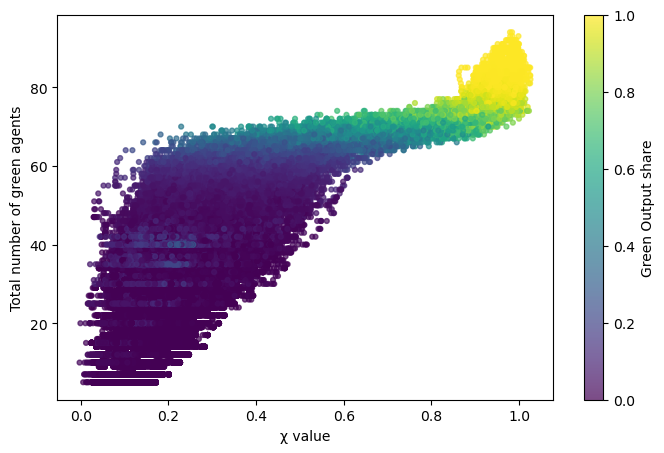

In [33]:
#Number of green farms vs chi values colored by green output share
# Randomly sample 20,000 points (without replacement)
sample_size = 20000
n = len(macro)

# Ensure we don't sample more than available
sample_size = min(sample_size, n)

idx = np.random.choice(n, sample_size, replace=False)

macro_sampled = macro[idx]
chi_sampled = chi0[idx]

#color map
#cmap=plt.cm.BrBG
#cmap=plt.cm.RdYlGn
cmap=plt.cm.viridis
# Plot
plt.figure(figsize=(8,5))
# sc = plt.scatter(chi0, macro[:,0],
#                  c=macro[:,1] 
#                  cmap=cmap,
#                  vmin=0, vmax=1 
#                  )

# Plot random points
# sc = plt.scatter(chi_sampled, macro_sampled[:,0],
#                  c=  macro_sampled[:, 1],
#                  cmap=cmap,
#     s=12, alpha=0.7,
#     vmin=0, vmax=1
# )

#plot all points
sc = plt.scatter(chi0, macro[:,0],
                 c=  macro[:, 1],
                 cmap=cmap,
    s=12, alpha=0.7,
    vmin=0, vmax=1
)
# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("Green Output share")

plt.ylabel(macro1)
plt.xlabel("χ value")

plt.savefig(f"{results_dir}/GFarms_vs_chi_vals_MR.png")

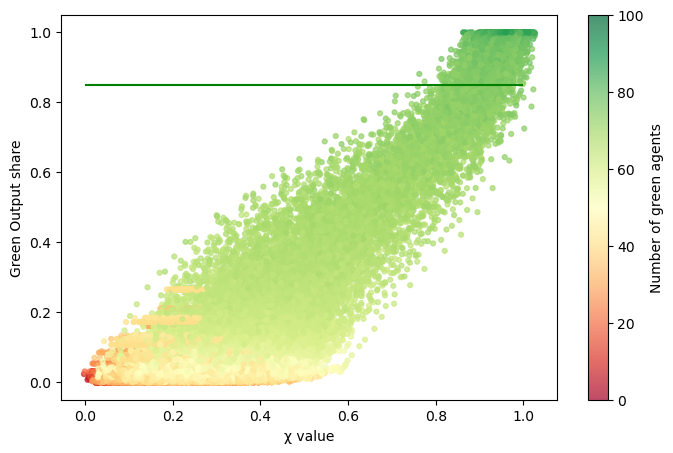

In [34]:
# chi-values against green Output share
cmap=plt.cm.RdYlGn
# Plot sample with random points
plt.figure(figsize=(8,5))
# sc = plt.scatter(chi_sampled, macro_sampled[:,1],
#                  c=  macro_sampled[:, 0],
#                  cmap=cmap,
#     s=12, alpha=0.7,
#     vmin=0, vmax=100
# )

sc = plt.scatter(chi0, macro[:,1],
                 c=  macro[:, 0],
                 cmap=cmap,
    s=12, alpha=0.7,
    vmin=0, vmax=100
)

plt.hlines(y=0.85, xmin=-0, xmax=1, colors='green')
plt.ylabel(macro2)
plt.xlabel("χ value")

# Add colorbar legend
cbar = plt.colorbar(sc)
cbar.set_label("Number of green agents")

plt.savefig(f"{results_dir}/GOS_vs_chi_vals_MR.png")

In [16]:
#Clustering results
noise_pct = np.sum(FNs.nodes == -1) / len(FNs.nodes) * 100
print(f"Result: {FNs.Nnodes} clusters, {noise_pct:.1f}% noise\n\n")
print(f"Cluster sizes - min: {FNs.nodes_size.min()}, max: {FNs.nodes_size.max()}, median: {np.median(FNs.nodes_size):.0f}")
print(f"Clusters per interval: {[np.sum(FNs.index_chi_node == i) for i in range(FIs.Nintervals)]}\n")

for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])

Result: 7 clusters, 7.5% noise


Cluster sizes - min: 1907, max: 106108, median: 3012
Clusters per interval: [2, 2, 3]

Node, interval, size: 0 0 25219
Node, interval, size: 1 0 106108
Node, interval, size: 2 1 2069
Node, interval, size: 3 1 44089
Node, interval, size: 4 2 1907
Node, interval, size: 5 2 2545
Node, interval, size: 6 2 3012


In [17]:
#BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=16, threshold =0, algorithm='mlp')
BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=100, threshold =1, algorithm='mlp')

100%|██████████| 200000/200000 [00:17<00:00, 11510.02it/s]


In [19]:
import pickle

#Save the BAM object
with open('BAM_object_N3.pkl', 'wb') as f:
    pickle.dump(BAM, f)

# Later, load it back
# with open('BAM_object_N4.pkl', 'rb') as f:
#     BAM = pickle.load(f)

In [20]:
BAM.A

array([[1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1]])

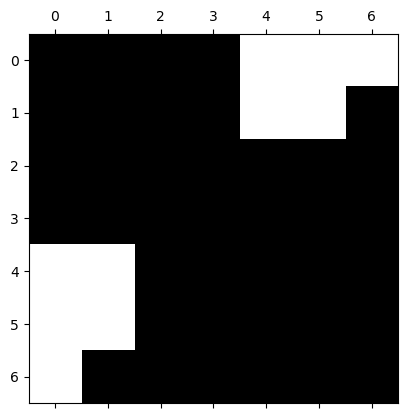

In [21]:
BG     =  BuildGraph(FNs, BAM)
G      =  BG.G

plt.spy(BAM.A) #show the sparsity pattern of a matrix.

In [23]:
chi_nodes          = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)
gradient_chi_nodes = np.zeros((FNs.Nnodes,FNs.Nnodes))

for i in range(FNs.Nnodes):
    for j in range(FNs.Nnodes):
         gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]

C:\Users\Flo\AppData\Local\Temp\ipykernel_8276\2595845277.py:6: RuntimeWarning: invalid value encountered in divide
  gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]
C:\Users\Flo\AppData\Local\Temp\ipykernel_8276\2595845277.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gradient_chi_nodes[i,j] = (chi_nodes[j] - chi_nodes[i]) / BAM.rmsd_nodes[i,j]


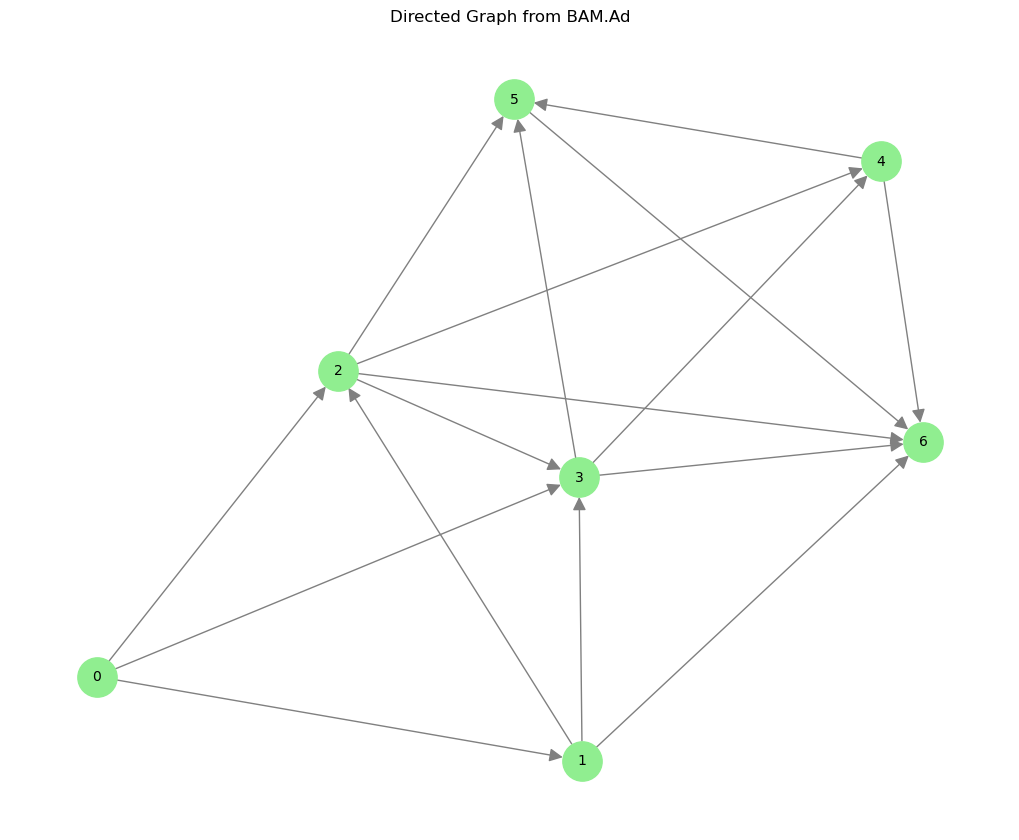

In [24]:
A = BAM.Ad.T
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

plt.figure(figsize=(10, 8))
#pos1 = nx.kamada_kawai_layout(G)  # or spring_layout, circular_layout, etc.
pos1 = nx.kamada_kawai_layout(BG.G)
# Rotate 180 degrees
pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightgreen',
    edge_color='gray',
    node_size=800,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>',
    font_size=10
)

plt.title("Directed Graph from BAM.Ad")
plt.show()


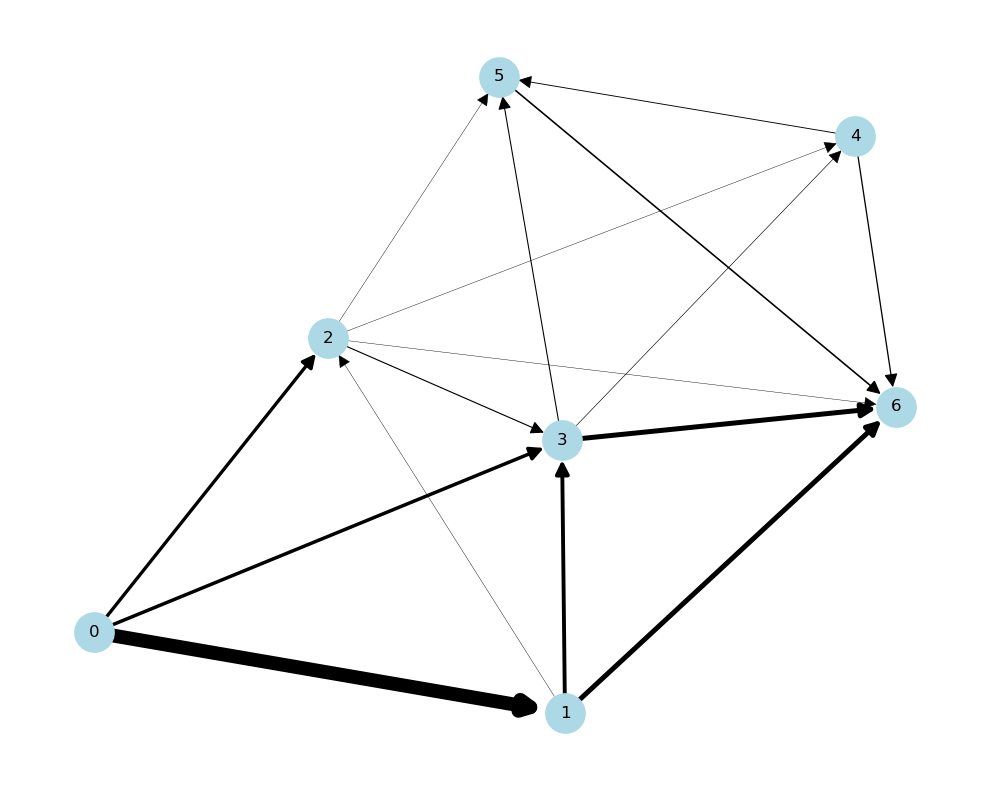

In [25]:
# Create directed graph with weights from C but directionality from Ad.T
Gd = nx.DiGraph()

for i in range(BAM.Ad.T.shape[0]):
    for j in range(BAM.Ad.T.shape[1]):
        if BAM.Ad.T[i, j] > 0:  # Only add edge if it exists in Ad (unidirectional)
            Gd.add_edge(i, j, weight=BAM.C[i, j])  # Use weight from C

# Extract weights
edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# Normalize with minimum width
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [10 * (w / max_weight) for w in edge_weights]
min_width = 0.3
edge_widths = [max(w, min_width) for w in edge_widths]

plt.figure(figsize=(10, 8))
# pos1 = nx.kamada_kawai_layout(BG.G)
# # Rotate 180 degrees
# pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Draw edges
nx.draw_networkx_edges(Gd, pos,
                       width=edge_widths,
                       arrowstyle='-|>',
                       arrowsize=20,
                       edge_color='black',
                       node_size=800)

# Draw nodes
nx.draw_networkx_nodes(Gd, pos,
                       node_size=800,
                       node_color='lightblue')

# Draw labels
nx.draw_networkx_labels(Gd, pos,
                        font_size=12,
                        font_color='black')

plt.axis('off')
plt.tight_layout()
plt.show()

Number of paths found: 25
Best path weight: 4605.0
Best path: [6, 3, 1, 0]
Found 25 paths

Top 5 paths:
Path 1: [6, 3, 1, 0]
Path 2: [6, 5, 4, 3, 1, 0]
Path 3: [6, 5, 3, 1, 0]
Path 4: [6, 3, 2, 1, 0]
Path 5: [6, 4, 3, 1, 0]


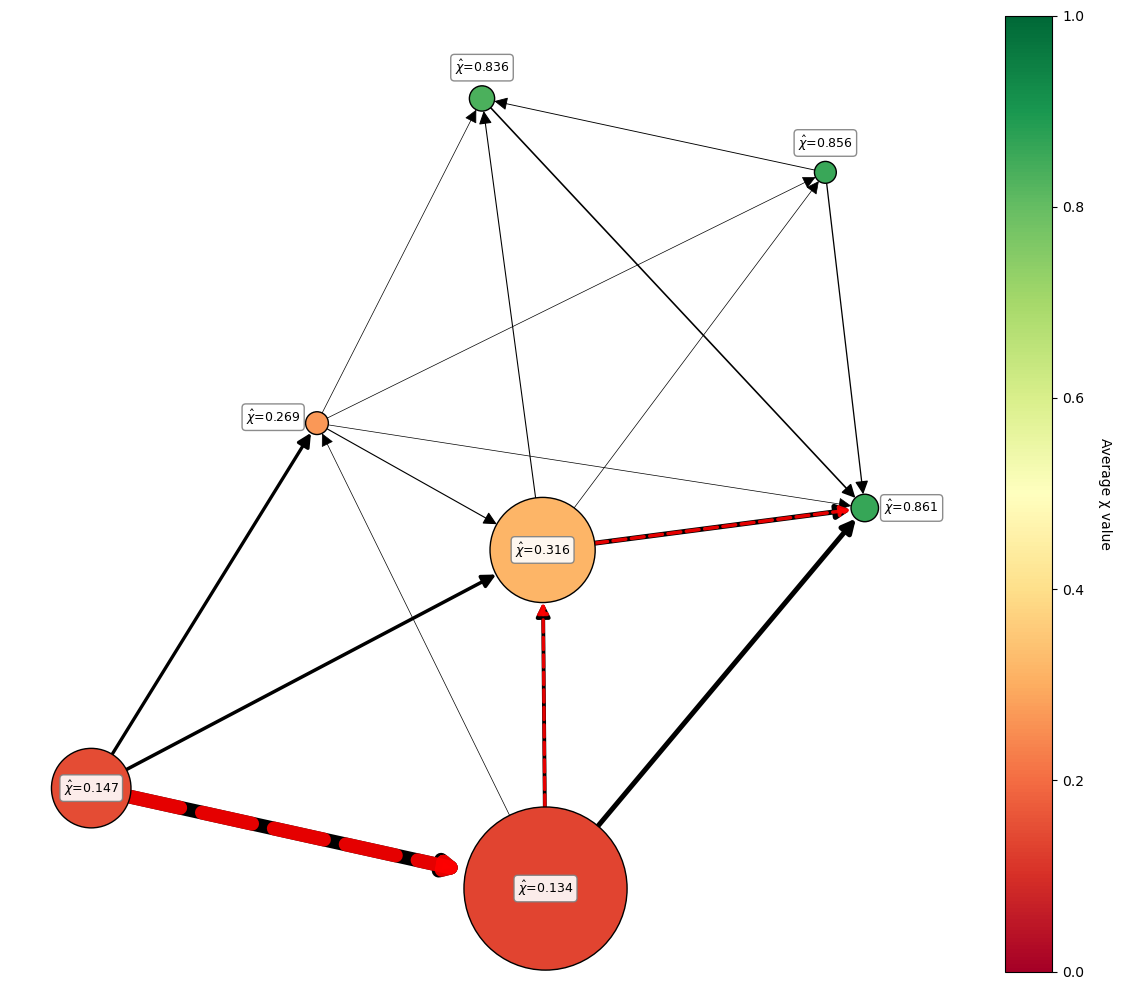

In [ ]:
# # Create directed graph with weights from C but directionality from Ad.T 
## Node size is given by cluster size and nodes are colored by average chi value in the cluster
## graph is labelled by their chi value

# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)

# #direct graph
# Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]

# # Extract weights directly from the directed graph edges
# edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# # Normalize but enforce minimum width
# max_weight = max(edge_weights)
# edge_widths = [10 * (w / max_weight) for w in edge_weights]

# # Ensure minimum width of 0.5
# min_width = 0.5
# edge_widths = [max(w, min_width) for w in edge_widths]

fig, ax = plt.subplots(figsize=(12, 10))

# Color nodes by chi values
node_colors = [chi_nodes[n] for n in BG.G.nodes()]

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.13 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

# Highlight path edges
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

nx.draw_networkx_edges(Gd, pos, edge_color='red',
                       edgelist=path_edges_flipped, 
                       alpha=0.9,
                       width=edge_widths,#[w*0.9 for w in edge_widths],
                       ax=ax,
                       style='--',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='-|>',
                    node_size=node_sizes_scaled, 
                        )


# Draw nodes colored by chi and sized by cluster size
nx.draw_networkx_nodes(Gd, pos, edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
chi_labels = {n: r"$\hat{\chi}$"+f"={chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
# chi_labels = {n: f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}


# Convert node sizes to dictionary
if isinstance(node_sizes_scaled, list):
    node_size_dict = {node: node_sizes_scaled[i] for i, node in enumerate(Gd.nodes())}
else:
    node_size_dict = node_sizes_scaled

scale_factor = 0.0015
padding = 0.05

label_pos = {}

# Manual overrides for specific nodes (adjust as needed)
manual_offsets = {
    # node_id: (x_offset, y_offset) in multiples of total_offset
    # Example: 3: (1.5, 0.5) means shift right and slightly up
    0:(0,0),
    1: (0,0),
    2: (-1.3,0.2),
    3: (0,0),
    6: (1.3,0)
    }

for node, (x, y) in pos.items():
    node_radius = np.sqrt(node_size_dict[node]) * scale_factor
    total_offset = node_radius + padding
    
    if node in manual_offsets:
        # Use manual override
        x_mult, y_mult = manual_offsets[node]
        label_pos[node] = (x + total_offset * x_mult, y + total_offset * y_mult)
    else:
        # Use automatic placement
        if y > 0:
            label_pos[node] = (x, y + total_offset)
        else:
            label_pos[node] = (x, y - total_offset)

nx.draw_networkx_labels(Gd, label_pos, labels=chi_labels, 
                       font_size=9, ax=ax,
                       bbox=dict(boxstyle="round,pad=0.3",
                                facecolor='white',
                                edgecolor='gray',
                                alpha=0.9))





# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=0, 
                                            vmax=1)
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

#plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
plt.savefig(f"{results_dir}/graph_with_most_probable_path_and_mean_chi_val_all_labels_MR.pdf",bbox_inches='tight')

Number of paths found: 25
Best path weight: 4605.0
Best path: [6, 3, 1, 0]
Found 25 paths

Top 5 paths:
Path 1: [6, 3, 1, 0]
Path 2: [6, 5, 4, 3, 1, 0]
Path 3: [6, 5, 3, 1, 0]
Path 4: [6, 3, 2, 1, 0]
Path 5: [6, 4, 3, 1, 0]


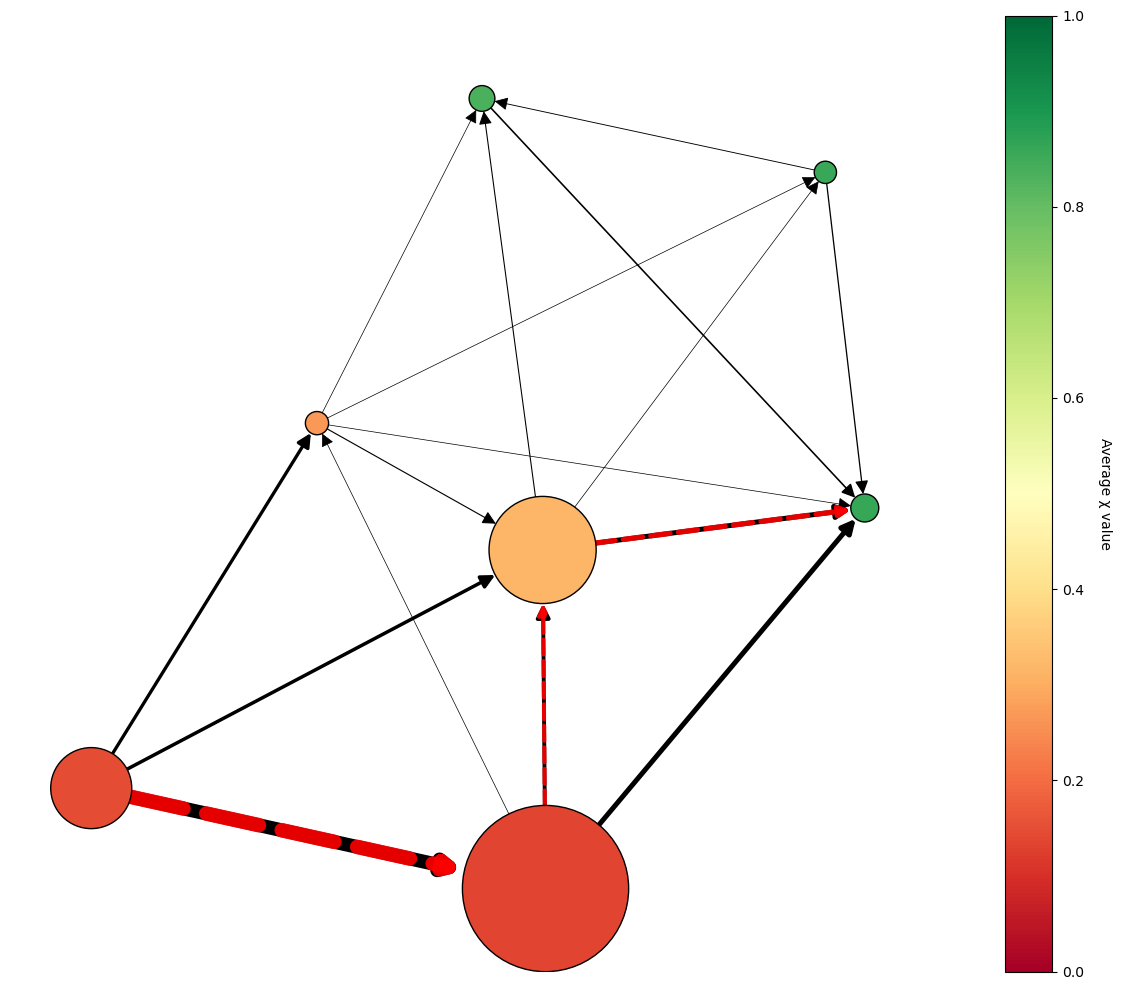

In [41]:
# # Create directed graph with weights from C but directionality from Ad.T 
## Node size is given by cluster size and nodes are colored by average chi value in the cluster
## 

# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)

# #direct graph
# Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]


fig, ax = plt.subplots(figsize=(12, 10))


# Color nodes by chi values
node_colors = [chi_nodes[n] for n in BG.G.nodes()]

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.135 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

#======================================================
# Highlight path edges
#=======================================================
# Get the best path and its edge weights
best_path = FP.list_paths[0]
best_path_edge_weights = FP.paths_edge_weights[0]

# Reverse the path
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

# Reverse the edge weights to match the flipped path
path_edge_weights_flipped = best_path_edge_weights[::-1]

# Calculate widths using the same normalization as the overall graph
max_weight = max(edge_weights)  # Same max_weight used for all edges
path_edge_widths = [7 * (w / max_weight) for w in path_edge_weights_flipped]

# Make path edges thicker than regular edges (multiply by factor)
path_edge_widths = [w * 1.5 for w in path_edge_widths]  # 50% thicker

# Ensure minimum width
min_width = 2.0
path_edge_widths = [max(w, min_width) for w in path_edge_widths]


# Draw path edges with variable widths
nx.draw_networkx_edges(Gd, pos, 
                       edge_color='red',
                       edgelist=path_edges_flipped, 
                       alpha=0.9,
                       width=path_edge_widths,  # Use path-specific widths
                       ax=ax,
                       style='--',
                       arrows=True,
                       arrowsize=15,
                       arrowstyle='-|>',
                       node_size=node_sizes_scaled)

#====================================================================
# Draw nodes colored by chi and sized by cluster size
#===================================================================
nx.draw_networkx_nodes(Gd, pos, edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
#chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}
#chi_labels = {n: f"{chi_nodes.tolist()[n][0]:.2f}" for n in BG.G.nodes()}

# nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
#                        font_size=9, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=0, 
                                            vmax=1)
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

#plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
# os.makedirs('graph_results', exist_ok=True)
plt.savefig(f"{results_dir}/graph_with_most_probable_path_and_mean_chi_val_MR.pdf",bbox_inches='tight')

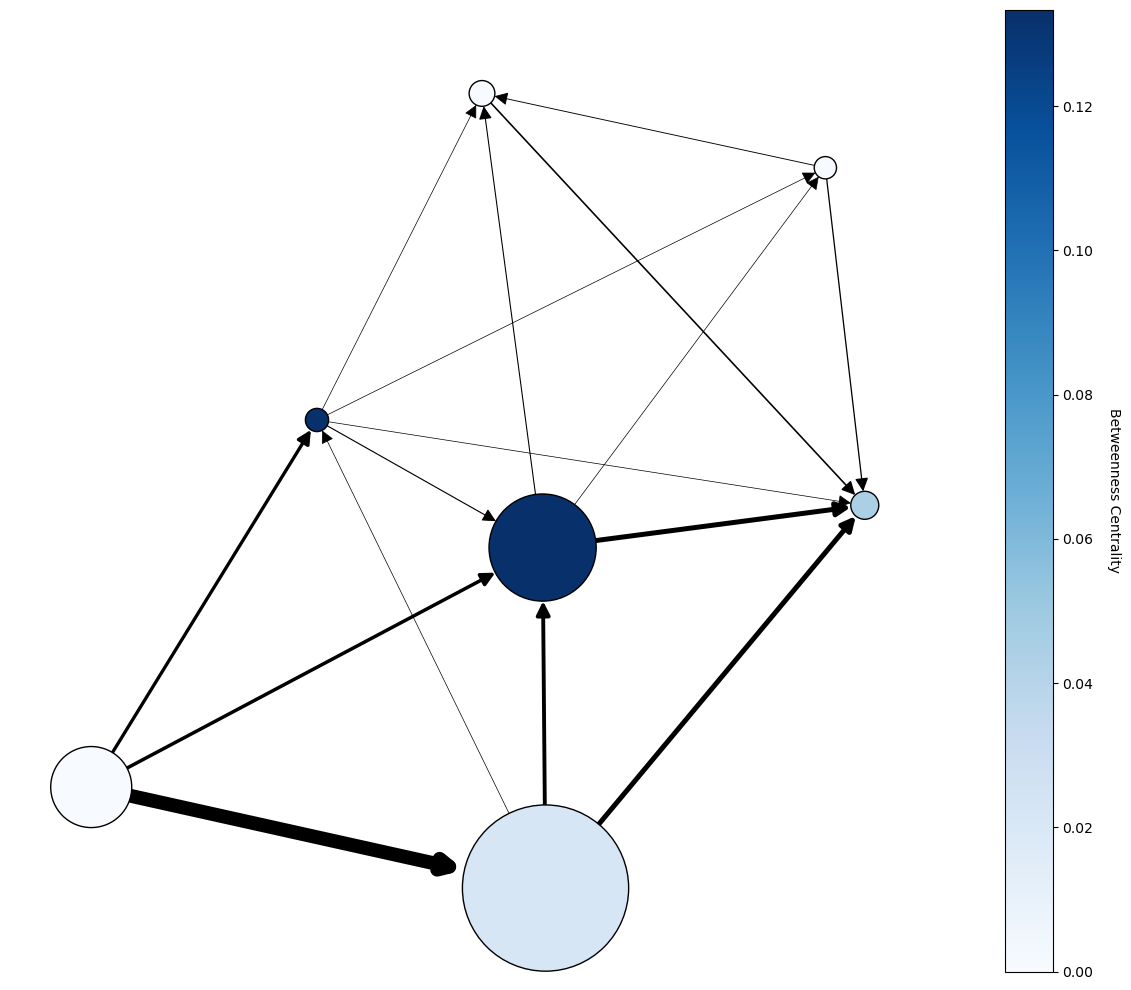

In [42]:
# Visualize Bottlenecks
# Calculate betweenness
betweenness = nx.betweenness_centrality(BG.G, weight='weight')

# Calculate flow through each node
flow_in = BAM.C.sum(axis=0)   # Incoming transitions
flow_out = BAM.C.sum(axis=1)  # Outgoing transitions
total_flow = flow_in + flow_out

# Calculate flow through each edge
edge_flows = []
for u, v in BG.G.edges():
    if BG.G.has_edge(u, v):
        # Get the weight/flow from the edge attributes
        flow = BG.G[u][v].get('weight', 1)  # Default to 1 if no weight
        edge_flows.append(flow)

# Extract weights directly from the directed graph edges
edge_weights = [Gd[u][v]['weight'] for u, v in Gd.edges()]

# Normalize but enforce minimum width
max_weight = max(edge_weights)
edge_widths = [10 * (w / max_weight) for w in edge_weights]

# Ensure minimum width of 0.5
min_width = 0.5
edge_widths = [max(w, min_width) for w in edge_widths]

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))

# Color by betweenness (bottleneck measure)
node_colors = [betweenness[n] for n in BG.G.nodes()]

# Size by flow (transition volume)
node_sizes_flow = [total_flow[n] * 0.045 for n in BG.G.nodes()]

nx.draw_networkx_edges( Gd, pos, 
    width=edge_widths, 
    ax=ax,
    arrows=True,
    arrowsize=20,
    arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)

nx.draw_networkx_nodes(Gd, pos, edgecolors ='black', 
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=plt.cm.Blues,#Reds,
                       vmin=min(node_colors),
                       vmax=max(node_colors),
                       ax=ax)

# chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
# nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
#                        font_size=12, ax=ax)



sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,#Reds, 
                           norm=plt.Normalize(vmin=min(node_colors),#0.2, 
                                              vmax=max(node_colors)
                                              ))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Betweenness Centrality', rotation=270, labelpad=20)

plt.axis('off')
plt.tight_layout()

#plt.savefig("N4intervals_results/graph_bottlenecks.pdf")
plt.savefig(f"{results_dir}/graph_bottlenecks_MR.pdf",bbox_inches='tight')

Previous code stars below

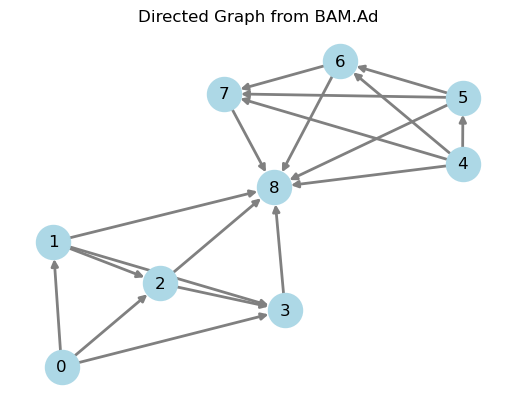

In [58]:
# Directed graph
#Gd = BG.Gd
Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

# pos1 = nx.kamada_kawai_layout(Gd)
# # Rotate 180 degrees
# pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Draw edges with arrows
nx.draw_networkx_edges(Gd, pos,
                    #    arrowstyle='-|>',
                    #    arrowsize=15,
                       edge_color='gray',
                       width=2,
                       node_size=600,
                       )

# Draw nodes
nx.draw_networkx_nodes(Gd, pos,
                       node_size=600,
                       node_color='lightblue')

# Draw labels
nx.draw_networkx_labels(Gd, pos,
                        font_size=12,
                        font_color='black')

plt.title("Directed Graph from BAM.Ad")
plt.axis('off')
plt.show()


Number of paths: 7
Found 7 paths

Top 5 paths:
Path 1: [8, 3, 2, 1, 0]
Path 2: [8, 1, 0]
Path 3: [8, 2, 1, 0]
Path 4: [8, 3, 1, 0]
Path 5: [8, 3, 0]


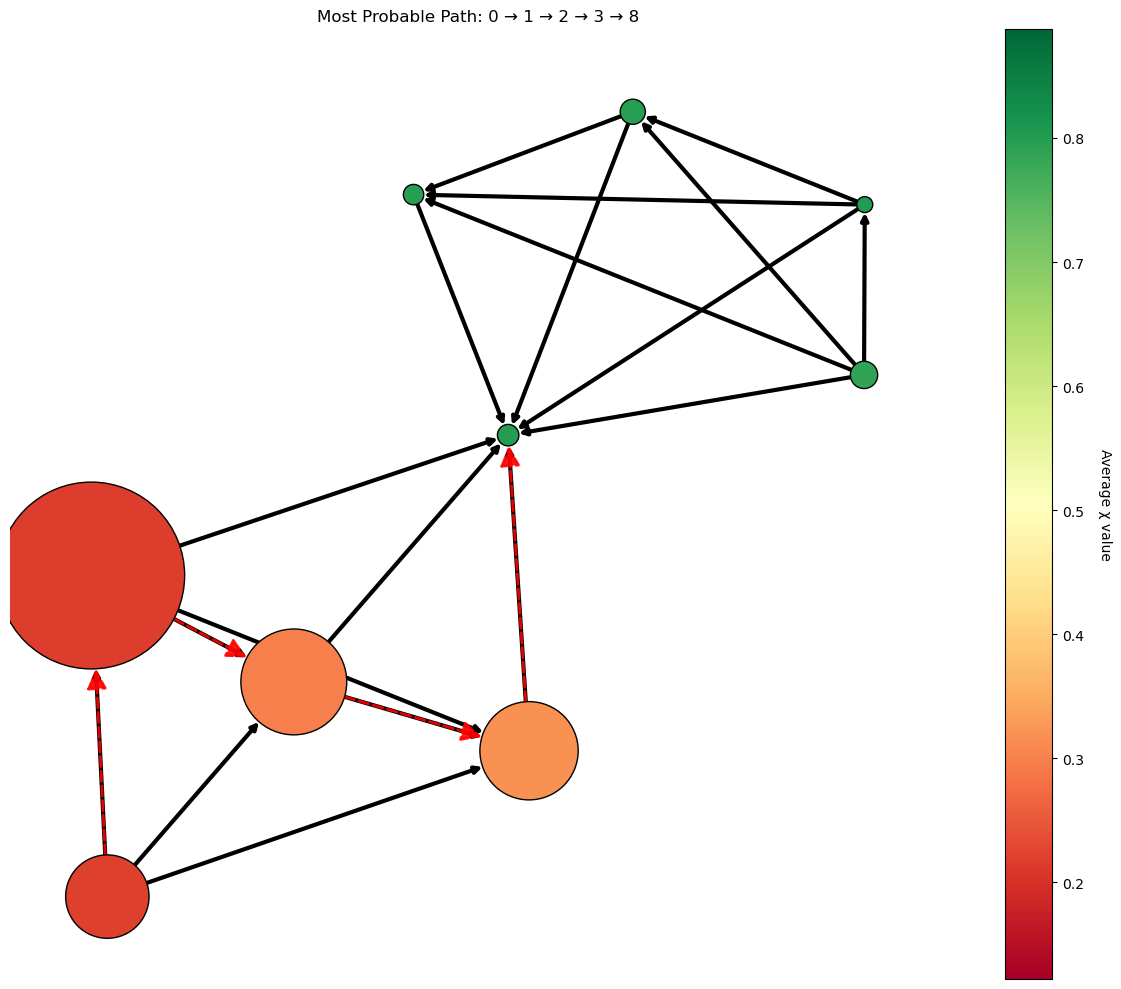

In [64]:
# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)
#direct graph
Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]

fig, ax = plt.subplots(figsize=(12, 10))
# pos1 = nx.kamada_kawai_layout(Gd)
# # Rotate 180 degrees
# pos = {node: (-x, -y) for node, (x, y) in pos1.items()}


# Color nodes by chi values
#node_colors = [chi_nodes[n] for n in BG.G.nodes()]

node_colors = []
for i,chi in enumerate(chi_nodes):
    node_colors.append(chi)

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.20 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=3, 
    ax=ax,
    # arrows=True,
    # arrowsize=30,
    # arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)



# Highlight path edges
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]

nx.draw_networkx_edges(Gd, pos, 
                       edgelist=path_edges_flipped, alpha=0.9,
                       width=2, edge_color='red',
                       ax=ax,
                       style='--',
                       arrows=True,
    arrowsize=30,
    arrowstyle='-|>',
                    node_size=node_sizes_scaled, 
                        )


# Draw nodes colored by chi and sized by cluster size
nx.draw_networkx_nodes(Gd, pos, 
                       edgecolors ='black',
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
#chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
# chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
# nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
#                        font_size=12, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=chi_nodes.min(), 
                                            vmax=chi_nodes.max())
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
#os.makedirs('graph_results', exist_ok=True)
plt.savefig(f"{results_dir}/graph_with_most_probable_path_and_mean_chi_vals.pdf")

Number of paths: 7
Found 7 paths

Top 5 paths:
Path 1: [8, 3, 2, 1, 0]
Path 2: [8, 1, 0]
Path 3: [8, 2, 1, 0]
Path 4: [8, 3, 1, 0]
Path 5: [8, 3, 0]


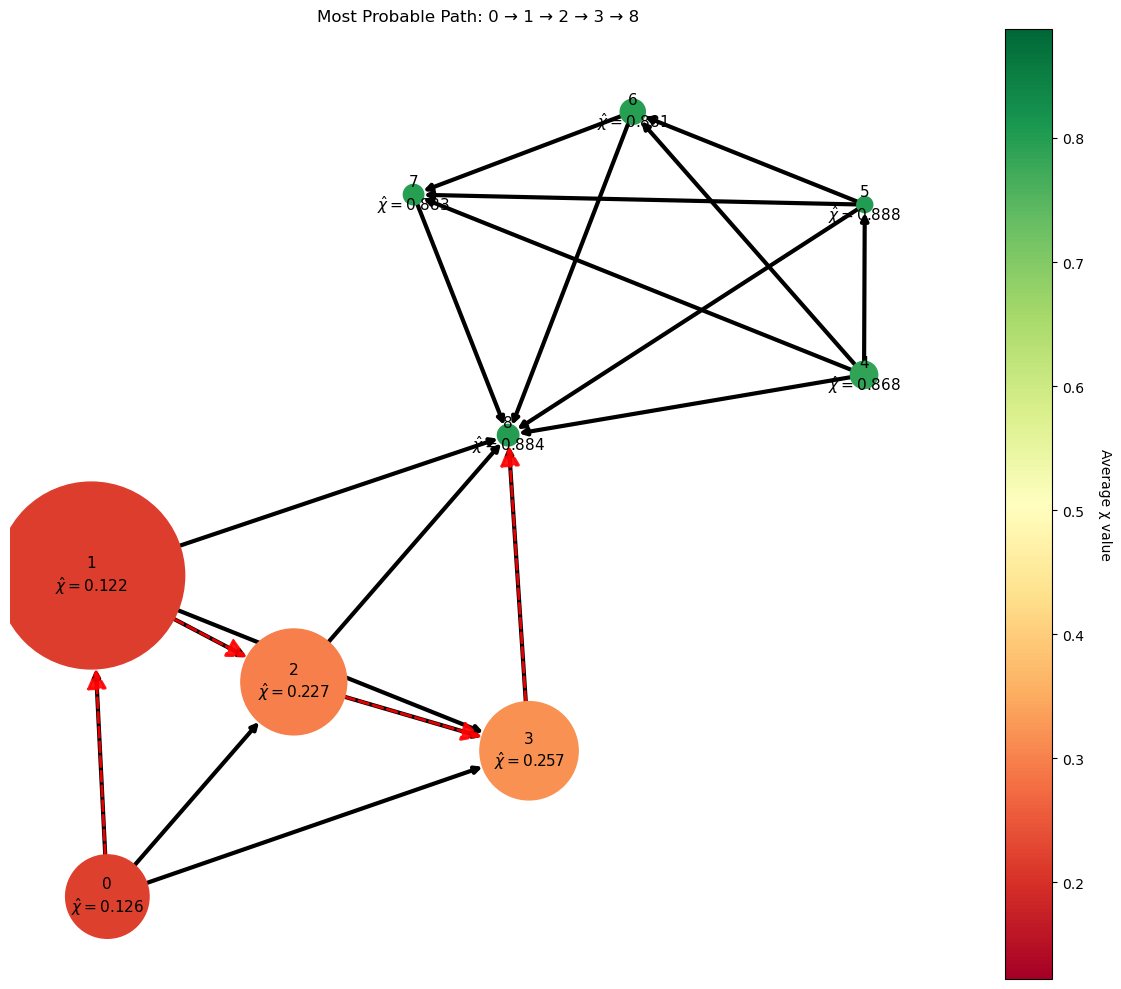

In [61]:
# Find paths
FP = FindPaths(FNs, BG, BAM, cutoff=10)
#direct graph
Gd = nx.from_numpy_array(BAM.Ad.T, create_using=nx.DiGraph())

#color map
cmap=plt.cm.RdYlGn

# Get the top paths
print(f"Found {len(FP.list_paths)} paths")
print("\nTop 5 paths:")
for i, path in enumerate(FP.list_paths[:5]):
    print(f"Path {i+1}: {path}")

# Visualize the most probable path
best_path = FP.list_paths[0]

fig, ax = plt.subplots(figsize=(12, 10))
# pos1 = nx.kamada_kawai_layout(Gd)
# # Rotate 180 degrees
# pos = {node: (-x, -y) for node, (x, y) in pos1.items()}


# Color nodes by chi values
#node_colors = [chi_nodes[n] for n in BG.G.nodes()]

node_colors = []
for i,chi in enumerate(chi_nodes):
    node_colors.append(chi)

# Size nodes by cluster size
node_sizes = [FNs.nodes_size[n] for n in BG.G.nodes()]

# Optional: scale the sizes for better visualization
# (multiply by a factor so they're visible but not too large)
node_sizes_scaled = [size * 0.20 for size in node_sizes]  # adjust multiplier as needed

nx.draw_networkx_edges( Gd, pos, 
    width=3, 
    ax=ax,
    # arrows=True,
    # arrowsize=30,
    # arrowstyle='-|>', 
    node_size=node_sizes_scaled, 
)



# Highlight path edges
best_path_reversed = best_path[::-1]
path_edges_flipped = [(best_path_reversed[i], best_path_reversed[i+1])
                      for i in range(len(best_path_reversed)-1)]
nx.draw_networkx_edges(Gd, pos, 
                       edgelist=path_edges_flipped, alpha=0.9,
                       width=2, edge_color='red',
                       ax=ax,
                       style='--',
                       arrows=True,
    arrowsize=30,
    arrowstyle='-|>',
                    node_size=node_sizes_scaled, 
                        )


# Draw nodes colored by chi and sized by cluster size
nx.draw_networkx_nodes(Gd, pos, 
                       node_size=node_sizes_scaled, 
                       node_color=node_colors,
                       cmap=cmap,
                       vmin=0,
                       vmax=1,
                       ax=ax)

# Replace the node ID labels with chi values
chi_labels = {n: f"{n}\n"+r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
#chi_labels = {n:f"{n}" for n in BG.G.nodes()}
# chi_labels = {n: r"$\hat{\chi}=$"+f"{chi_nodes.tolist()[n][0]:.3f}" for n in BG.G.nodes()}
nx.draw_networkx_labels(Gd, pos, labels=chi_labels, 
                       font_size=11, ax=ax)







# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap , 
                           norm=plt.Normalize(vmin=chi_nodes.min(), 
                                            vmax=chi_nodes.max())
                                             )
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average χ value', rotation=270, labelpad=20)

plt.title(f"Most Probable Path: {' → '.join(map(str, best_path[::-1]))}")
plt.axis('off')
plt.tight_layout()
#plt.show()
# Create results directory
#os.makedirs('graph_results', exist_ok=True)
#plt.savefig(f"{results_dir}/graph_with_most_probable_path_and_mean_chi_vals.pdf")

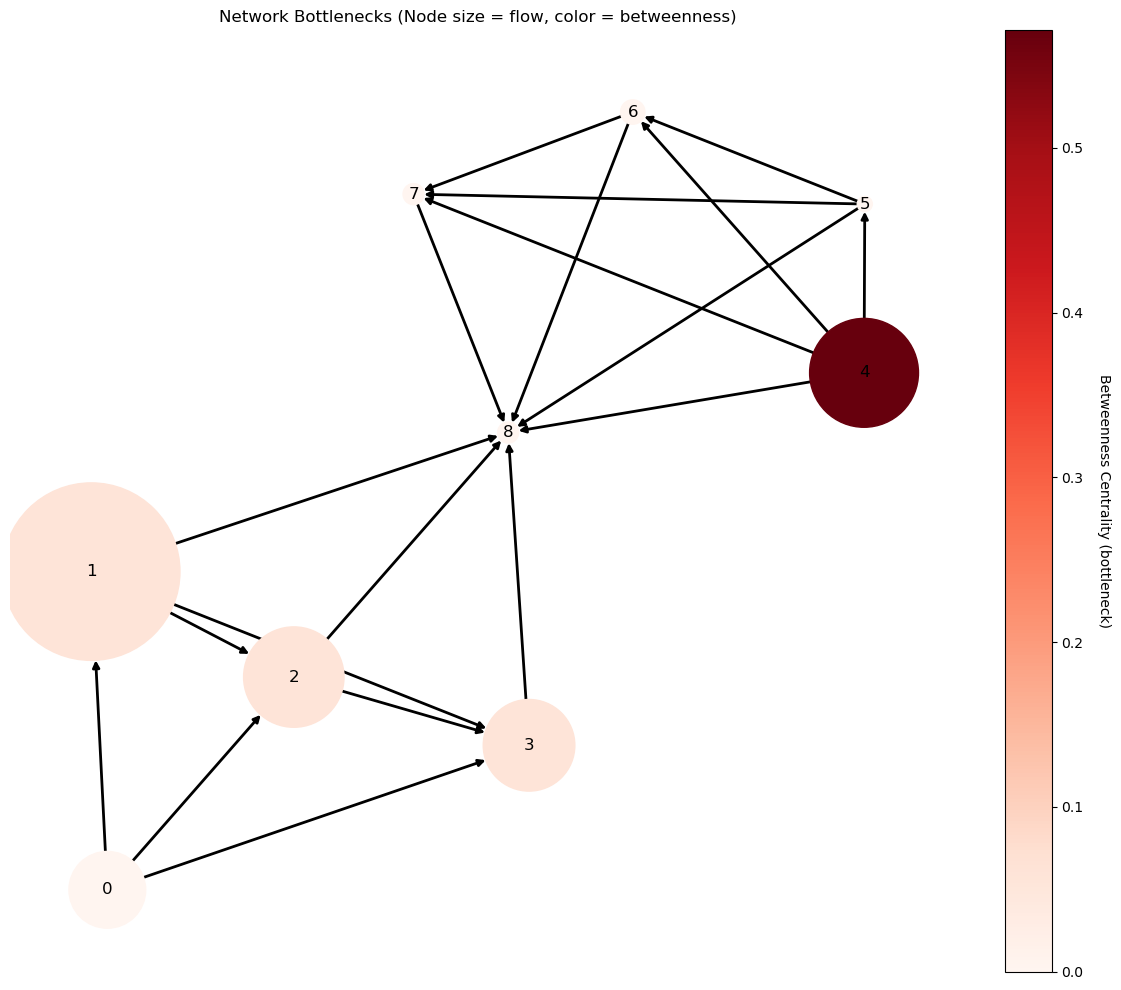

In [51]:
# Visualize Bottlenecks
# Calculate betweenness
betweenness = nx.betweenness_centrality(BG.G, weight='weight')

# Calculate flow through each node
flow_in = BAM.C.sum(axis=0)   # Incoming transitions
flow_out = BAM.C.sum(axis=1)  # Outgoing transitions
total_flow = flow_in + flow_out

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
#pos = nx.spring_layout(G, center=[0,0], seed = 27) 
# pos1 = nx.kamada_kawai_layout(Gd)
# # Rotate 180 degrees
# pos = {node: (-x, -y) for node, (x, y) in pos1.items()}

# Color by betweenness (bottleneck measure)
node_colors = [betweenness[n] for n in BG.G.nodes()]

# Size by flow (transition volume)
node_sizes_flow = [total_flow[n] * 0.045 for n in BG.G.nodes()]  # Adjust multiplier as needed

nx.draw_networkx_edges(Gd, pos, width=2, ax=ax,
                       node_size=node_sizes_flow
                       )

nx.draw_networkx_nodes(Gd, pos, 
                       node_size=node_sizes_flow,
                       node_color=node_colors,
                       cmap=plt.cm.Reds,  # Red = high bottleneck
                       ax=ax)

nx.draw_networkx_labels(Gd, pos, font_size=12, ax=ax)


sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                           norm=plt.Normalize(vmin=0, vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Betweenness Centrality (bottleneck)', rotation=270, labelpad=20)

plt.title("Network Bottlenecks (Node size = flow, color = betweenness)")
plt.axis('off')
plt.tight_layout()
#plt.show()
#plt.savefig("graph_results/graph_with_bottlenecks_and_flow_between_nodes.pdf")


In [ ]:
# Total flow through each node
flow_in = BAM.C.sum(axis=0)   # Incoming transitions
flow_out = BAM.C.sum(axis=1)  # Outgoing transitions
total_flow = flow_in + flow_out

print("\nFlow through nodes (transition count):")
for i in np.argsort(total_flow)[::-1]:
    print(f"Node {i}: {total_flow[i]:.0f} total transitions (in: {flow_in[i]:.0f}, out: {flow_out[i]:.0f})")